**Heart Attack Analysis**

У нас имеется DataFrame, содержащий информацию о пациенте и столбец 'output', который сообщает нам склонность человека к сердечному приступу(0-маловероятно, 1-имеет наибольшую опасность).

**Цель:**

 Необходимо создать модель для бинарной класификации пациентов, для выявления тех, кто находится в зоне риска. Точность модели должна превышать 80%.

In [1]:
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
upload = files.upload()
df = pd.read_csv('heart.csv')

Saving heart.csv to heart.csv


In [4]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df.shape

(303, 14)

Можно заметить, что DataFrame имеет небольшие размеры.

In [6]:
duplicates = df[df.duplicated()]

In [7]:
duplicates

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


Имеется только 1 дубликат. Его следует исключить из наших данных.

In [8]:
df = df.drop_duplicates()

Рассмотрим распрелеление параметров пациентов. Большинство количественных переменных имеюся нормальное распределние с небольшими перекосами.

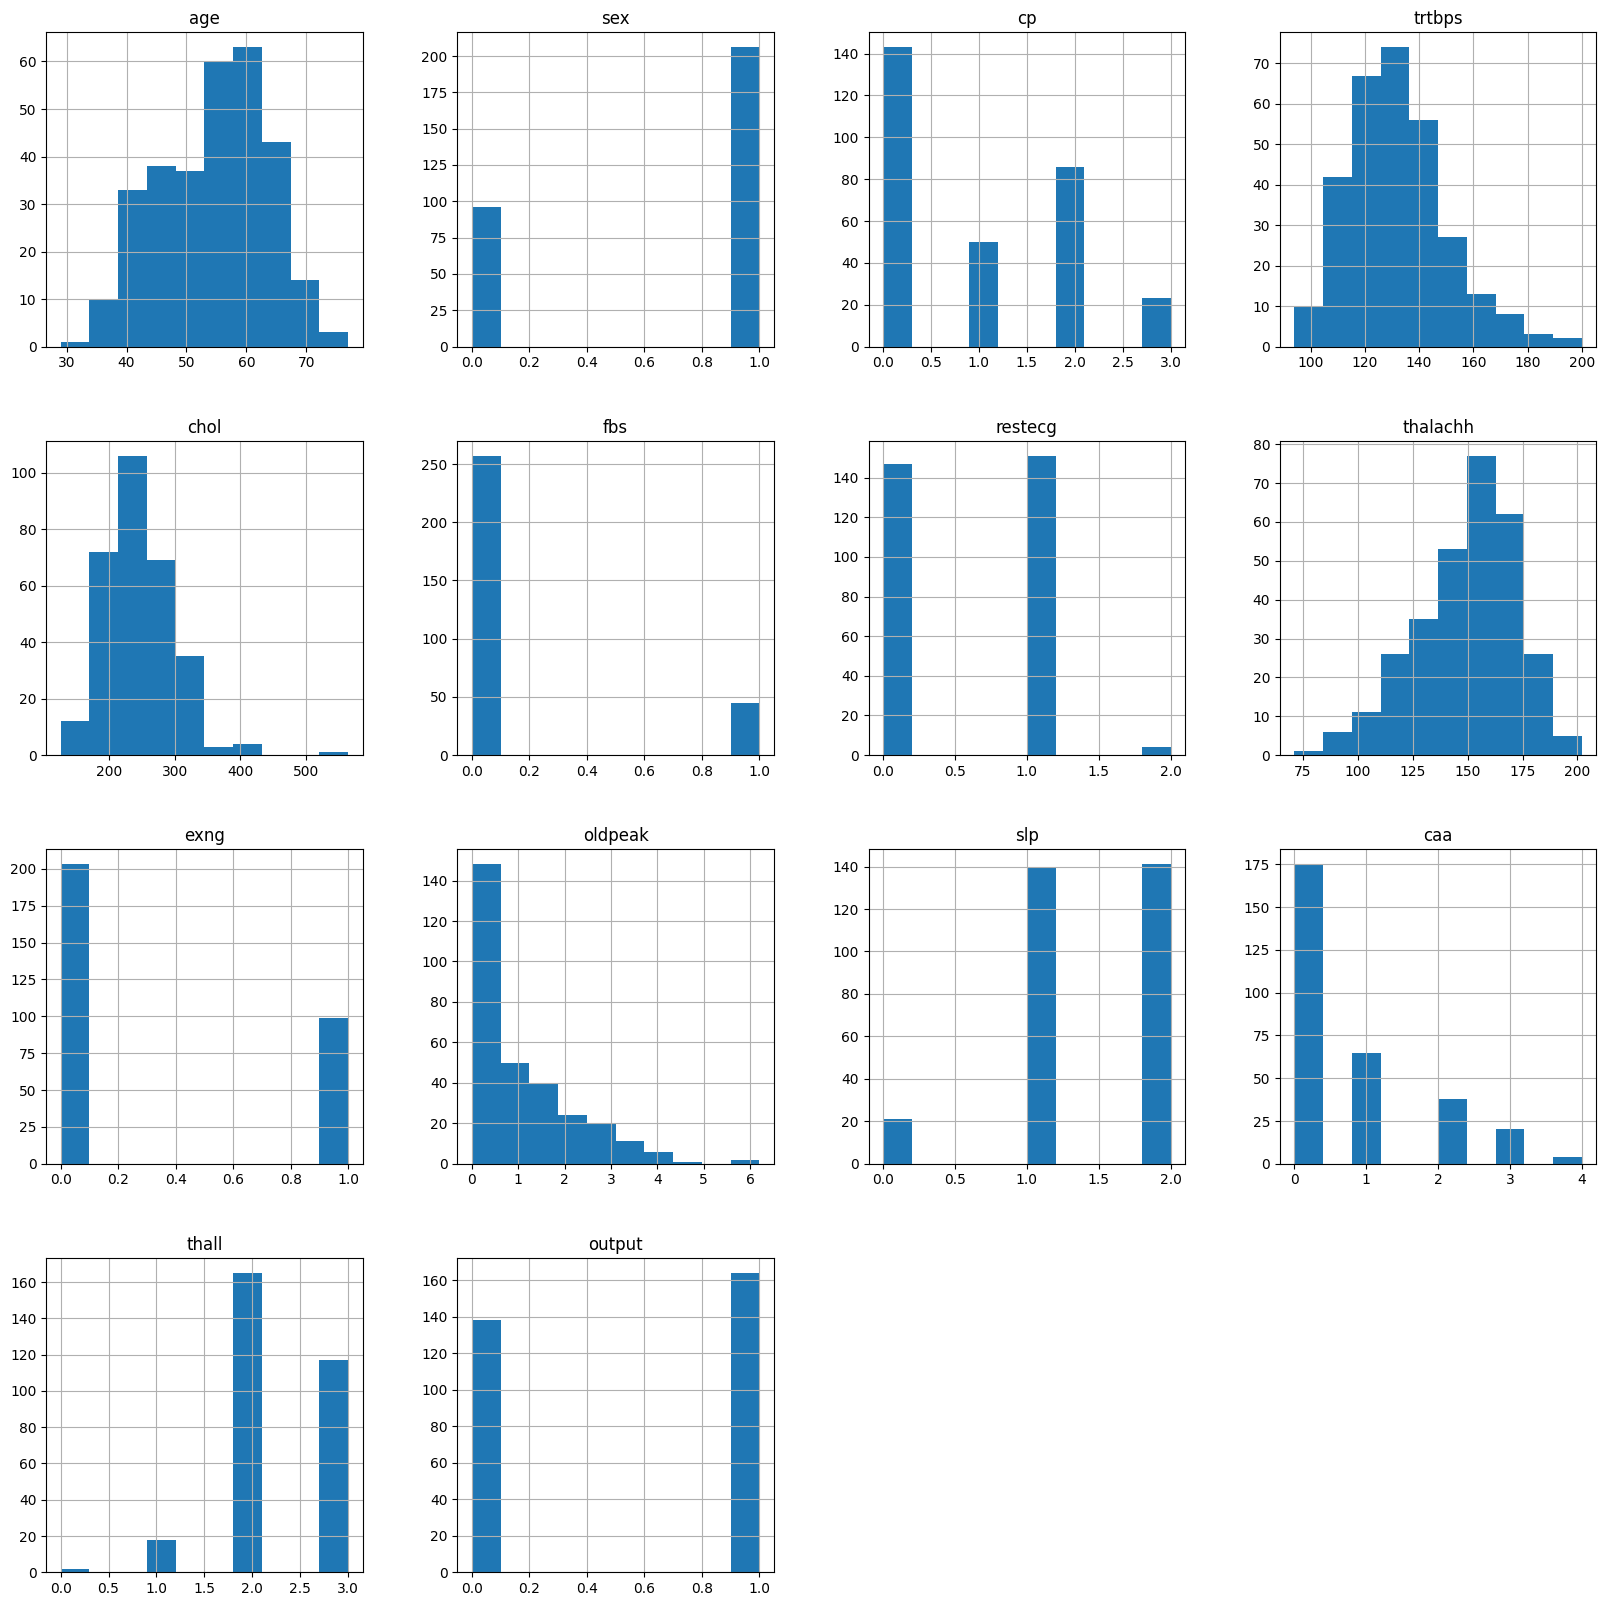

In [9]:
df.hist(figsize=(20,20))

plt.show()

In [10]:
df.corr()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
age,1.000000,-0.094962,-0.063107,0.283121,0.207216,0.119492,-0.111590,-0.395235,0.093216,0.206040,-0.164124,0.302261,0.065317,-0.221476
sex,-0.094962,1.000000,-0.051740,-0.057647,-0.195571,0.046022,-0.060351,-0.046439,0.143460,0.098322,-0.032990,0.113060,0.211452,-0.283609
cp,-0.063107,-0.051740,1.000000,0.046486,-0.072682,0.096018,0.041561,0.293367,-0.392937,-0.146692,0.116854,-0.195356,-0.160370,0.432080
trtbps,0.283121,-0.057647,0.046486,1.000000,0.125256,0.178125,-0.115367,-0.048023,0.068526,0.194600,-0.122873,0.099248,0.062870,-0.146269
chol,0.207216,-0.195571,-0.072682,0.125256,1.000000,0.011428,-0.147602,-0.005308,0.064099,0.050086,0.000417,0.086878,0.096810,-0.081437
fbs,0.119492,0.046022,0.096018,0.178125,0.011428,1.000000,-0.083081,-0.007169,0.024729,0.004514,-0.058654,0.144935,-0.032752,-0.026826
restecg,-0.111590,-0.060351,0.041561,-0.115367,-0.147602,-0.083081,1.000000,0.041210,-0.068807,-0.056251,0.090402,-0.083112,-0.010473,0.134874
thalachh,-0.395235,-0.046439,0.293367,-0.048023,-0.005308,-0.007169,0.041210,1.000000,-0.377411,-0.342201,0.384754,-0.228311,-0.094910,0.419955
exng,0.093216,0.143460,-0.392937,0.068526,0.064099,0.024729,-0.068807,-0.377411,1.000000,0.286766,-0.256106,0.125377,0.205826,-0.435601
oldpeak,0.206040,0.098322,-0.146692,0.194600,0.050086,0.004514,-0.056251,-0.342201,0.286766,1.000000,-0.576314,0.236560,0.209090,-0.429146


In [11]:
df['output'].value_counts()

,count
output,
1,164
0,138


In [12]:
df.isnull().any()

,0
age,False
sex,False
cp,False
trtbps,False
chol,False
fbs,False
restecg,False
thalachh,False
exng,False
oldpeak,False


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trtbps    302 non-null    int64  
 4   chol      302 non-null    int64  
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalachh  302 non-null    int64  
 8   exng      302 non-null    int64  
 9   oldpeak   302 non-null    float64
 10  slp       302 non-null    int64  
 11  caa       302 non-null    int64  
 12  thall     302 non-null    int64  
 13  output    302 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 35.4 KB


In [14]:
target = df['output']
df_trans = df.drop(['output'], axis = 1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_trans, target, test_size=0.33,
                                                    random_state=7, shuffle=True)

In [16]:
scaler = RobustScaler()

#SimpleImputer(strategy='mean') для заполнения пустых ящеик

In [17]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [19]:
rfc = RandomForestClassifier(random_state=7)
rfc.fit(X_train, y_train)
importance_df = pd.DataFrame({
    'features' : df_trans.columns,
    'importance' : rfc.feature_importances_
}).sort_values(by='importance', ascending=False)


In [20]:
importance_df

,features,importance
7,thalachh,0.121028
9,oldpeak,0.119144
11,caa,0.118984
2,cp,0.113316
12,thall,0.109424
4,chol,0.086393
0,age,0.085633
3,trtbps,0.075541
8,exng,0.053522
10,slp,0.051390


In [21]:
params = {'n_neighbors' : [5, 7, 10], 'weights' : ['uniform', 'distance'], }
clf = KNeighborsClassifier()

grid_search = GridSearchCV(clf, params, cv=5)

In [22]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 7, 10],
                         'weights': ['uniform', 'distance']})

In [23]:
grid_search.best_score_

0.8220731707317073

In [24]:
grid_search.best_params_

{'n_neighbors': 5, 'weights': 'uniform'}

In [25]:
clf = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform')

In [26]:
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [27]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.81

В итоге мы получили модель с точность ~81-82%, что считаю достаточно неплохим результатом.